predict: overall survival and progression free survival based on genomic and clinical features
we need to identify key biomarkers and clinical factors influencing patient survival
choose an approach for the prediction model
quantigy feature contributions to survival outcomes using shap analysis

In [101]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [364]:
pip install miceforest

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------------------ --- 1.3/1.5 MB 9.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [55]:
data = pd.read_csv("./Dataset/METABRIC_RNA_Mutation.csv", engine="python")
# patient id is not relevant in our model
data.drop('patient_id', axis=1, inplace=True)

data.describe(include='all')

,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
count,1904.000000,1882,1904,1889,1850,1904.000000,1904,1904.000000,1874,1904,...,1904,1904,1904,1904,1904,1904,1904,1904,1904,1904
unique,NaN,2,2,6,3,NaN,7,NaN,2,2,...,5,5,5,4,4,3,3,3,3,2
top,NaN,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NaN,LumA,NaN,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
freq,NaN,1127,1903,1500,939,NaN,679,NaN,1445,1459,...,1900,1900,1900,1901,1901,1902,1902,1902,1902,1903
mean,61.087054,NaN,NaN,NaN,NaN,0.207983,NaN,2.643908,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,12.978711,NaN,NaN,NaN,NaN,0.405971,NaN,1.228615,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,21.930000,NaN,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,51.375000,NaN,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,61.770000,NaN,NaN,NaN,NaN,0.000000,NaN,3.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,70.592500,NaN,NaN,NaN,NaN,0.000000,NaN,3.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
data.head()

,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
1,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
2,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
3,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
4,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0


In [16]:
print(data['tumor_other_histologic_subtype'].unique())
print(data['oncotree_code'].unique())
print(data['cancer_type'].unique())
print(data['cancer_type_detailed'].unique())


['Ductal/NST' 'Mixed' 'Lobular' 'Tubular/ cribriform' 'Mucinous'
 'Medullary' 'Other' nan 'Metaplastic']
['IDC' 'MDLC' 'ILC' 'IMMC' 'BREAST' nan 'MBC']
['Breast Cancer' 'Breast Sarcoma']
['Breast Invasive Ductal Carcinoma'
 'Breast Mixed Ductal and Lobular Carcinoma'
 'Breast Invasive Lobular Carcinoma'
 'Breast Invasive Mixed Mucinous Carcinoma' 'Breast' nan
 'Metaplastic Breast Cancer']


Issue: These variables provide different names or classifications for cancer type but essentially convey the same information.

Solution: Only one of these variables should be included in the model to avoid redundancy.

# Data Visualisation

The below graphs shows the distribution of key clinical variables for patients who survived vs who did not survived

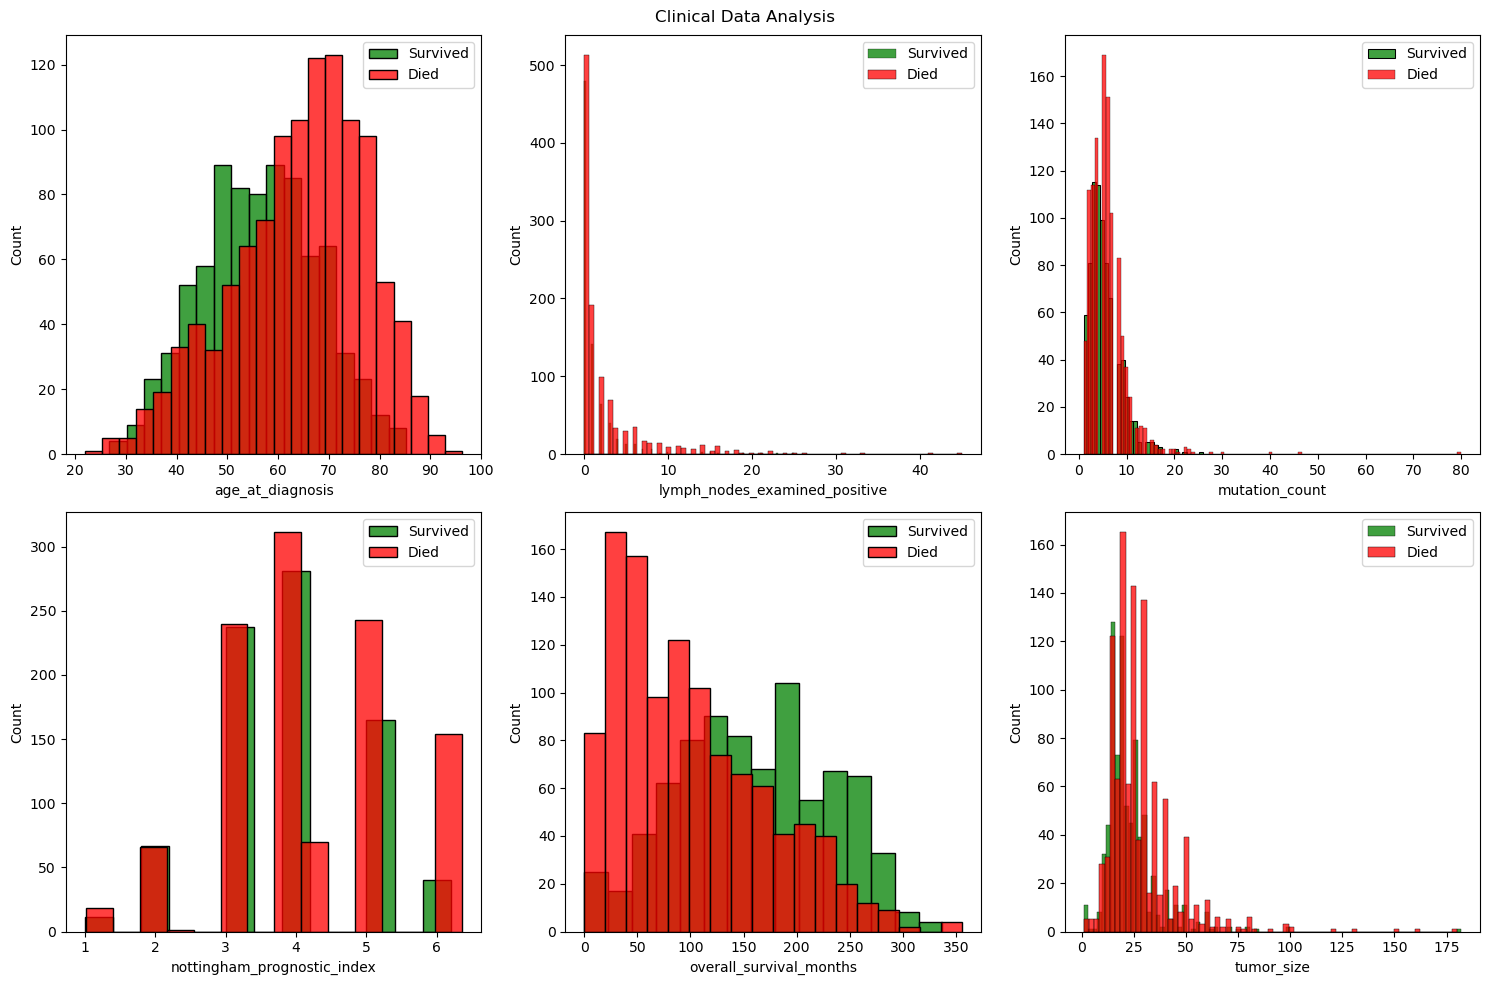

In [7]:
columns = ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index', 'overall_survival_months', 'tumor_size' ]   
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Clinical Data Analysis')
    
# sns.set(style="whitegrid")

for i,ax in zip(data[columns].columns,axs.flatten()):
    sns.histplot(data[i][data['overall_survival']==1], color='g', label = 'Survived',ax=ax)
    sns.histplot(data[i][data['overall_survival']==0], color='r', label = 'Died',ax=ax)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

1. age at diagnosis: 
    * survivors tend to be younger, with peak between 40-60 years
    * higher mortality in older patients (age > 60 years)
2. lymph_nodes_examined_positive:
    * with an increase in the positive lymph nodes the mortality rate is higher than the survival rate
    * survivors also tends to have fewer lymph nodes than those died 
3. mutation_count:
    * higher mutation appears to correlate with increased mortality
4. nottingham_prognostic_index
    * Patients with lower NPI (<4) tend to survive more
5. overall_survival_months
    * Non-survivors have shorter survival periods (mostly <100 months)
    * Survivors show a wider range, with many living beyond 150+ months
6. tumor_size
    * Small tumors (<50mm) are more common in survivors
    * Larger tumors correlate with increased mortality

### Expression levels of different genes vs survival rates
The below graphs shows the distribution of gene mutation values for different genes, categorized by survival status.

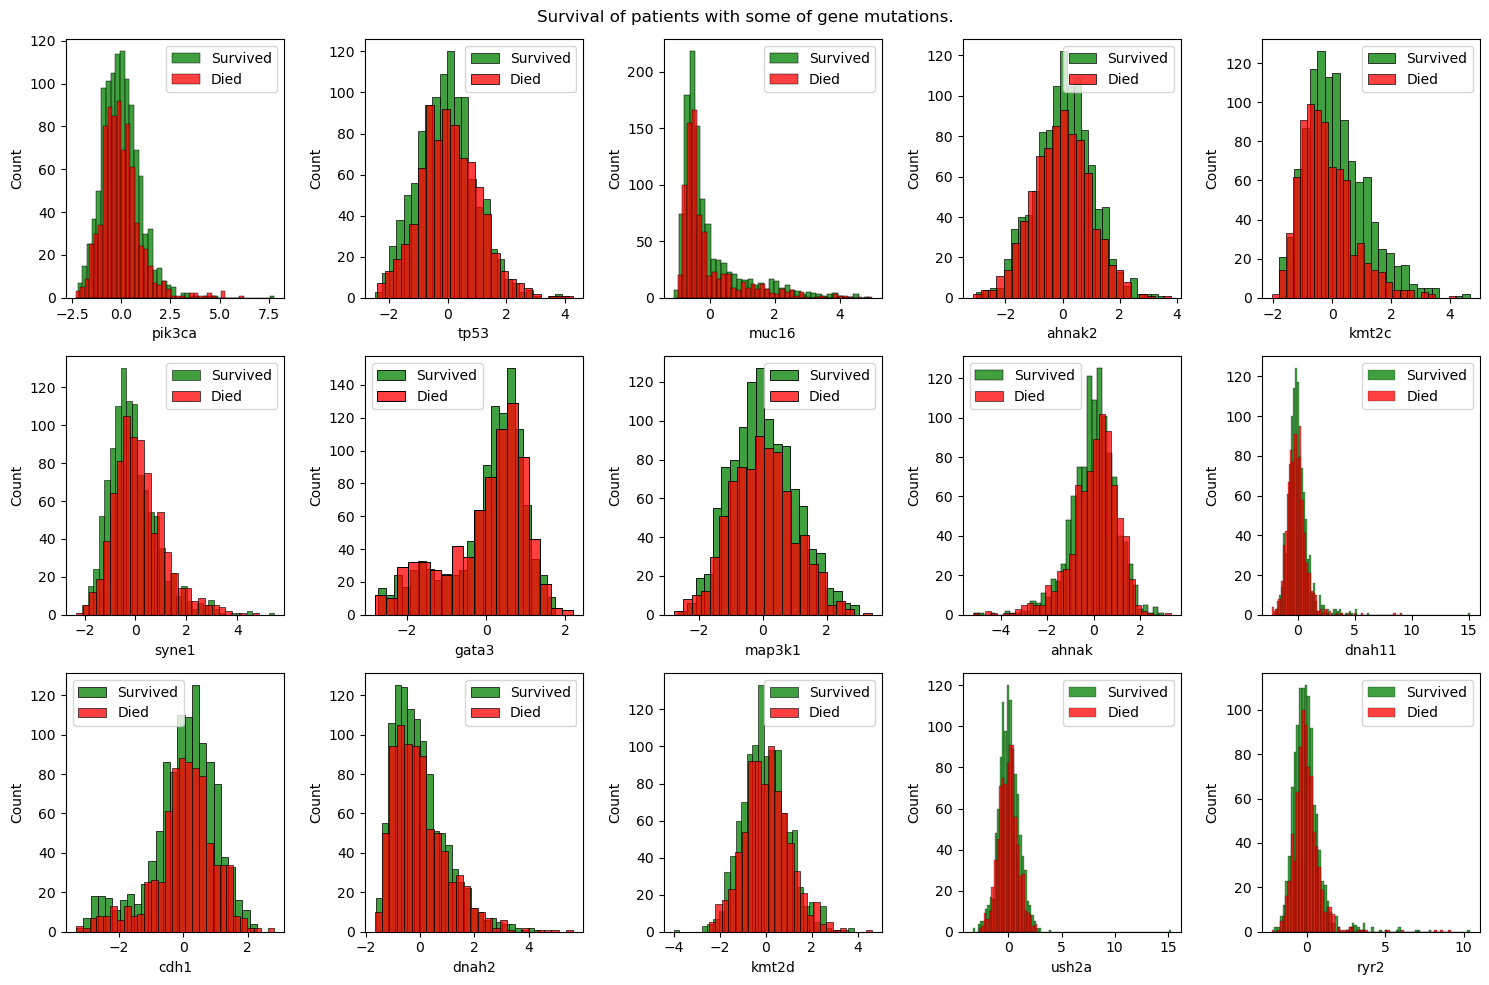

In [19]:
columns = ['pik3ca','tp53','muc16','ahnak2','kmt2c','syne1','gata3','map3k1','ahnak','dnah11','cdh1','dnah2','kmt2d','ush2a','ryr2']   
fig, axs = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('Survival of patients with some of gene mutations.')

for i,ax in zip(data[columns].columns,axs.flatten()):
    sns.histplot(data[i][data['overall_survival']==0], color='g', label = 'Survived',ax=ax)
    sns.histplot(data[i][data['overall_survival']==1], color='r', label = 'Died',ax=ax)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

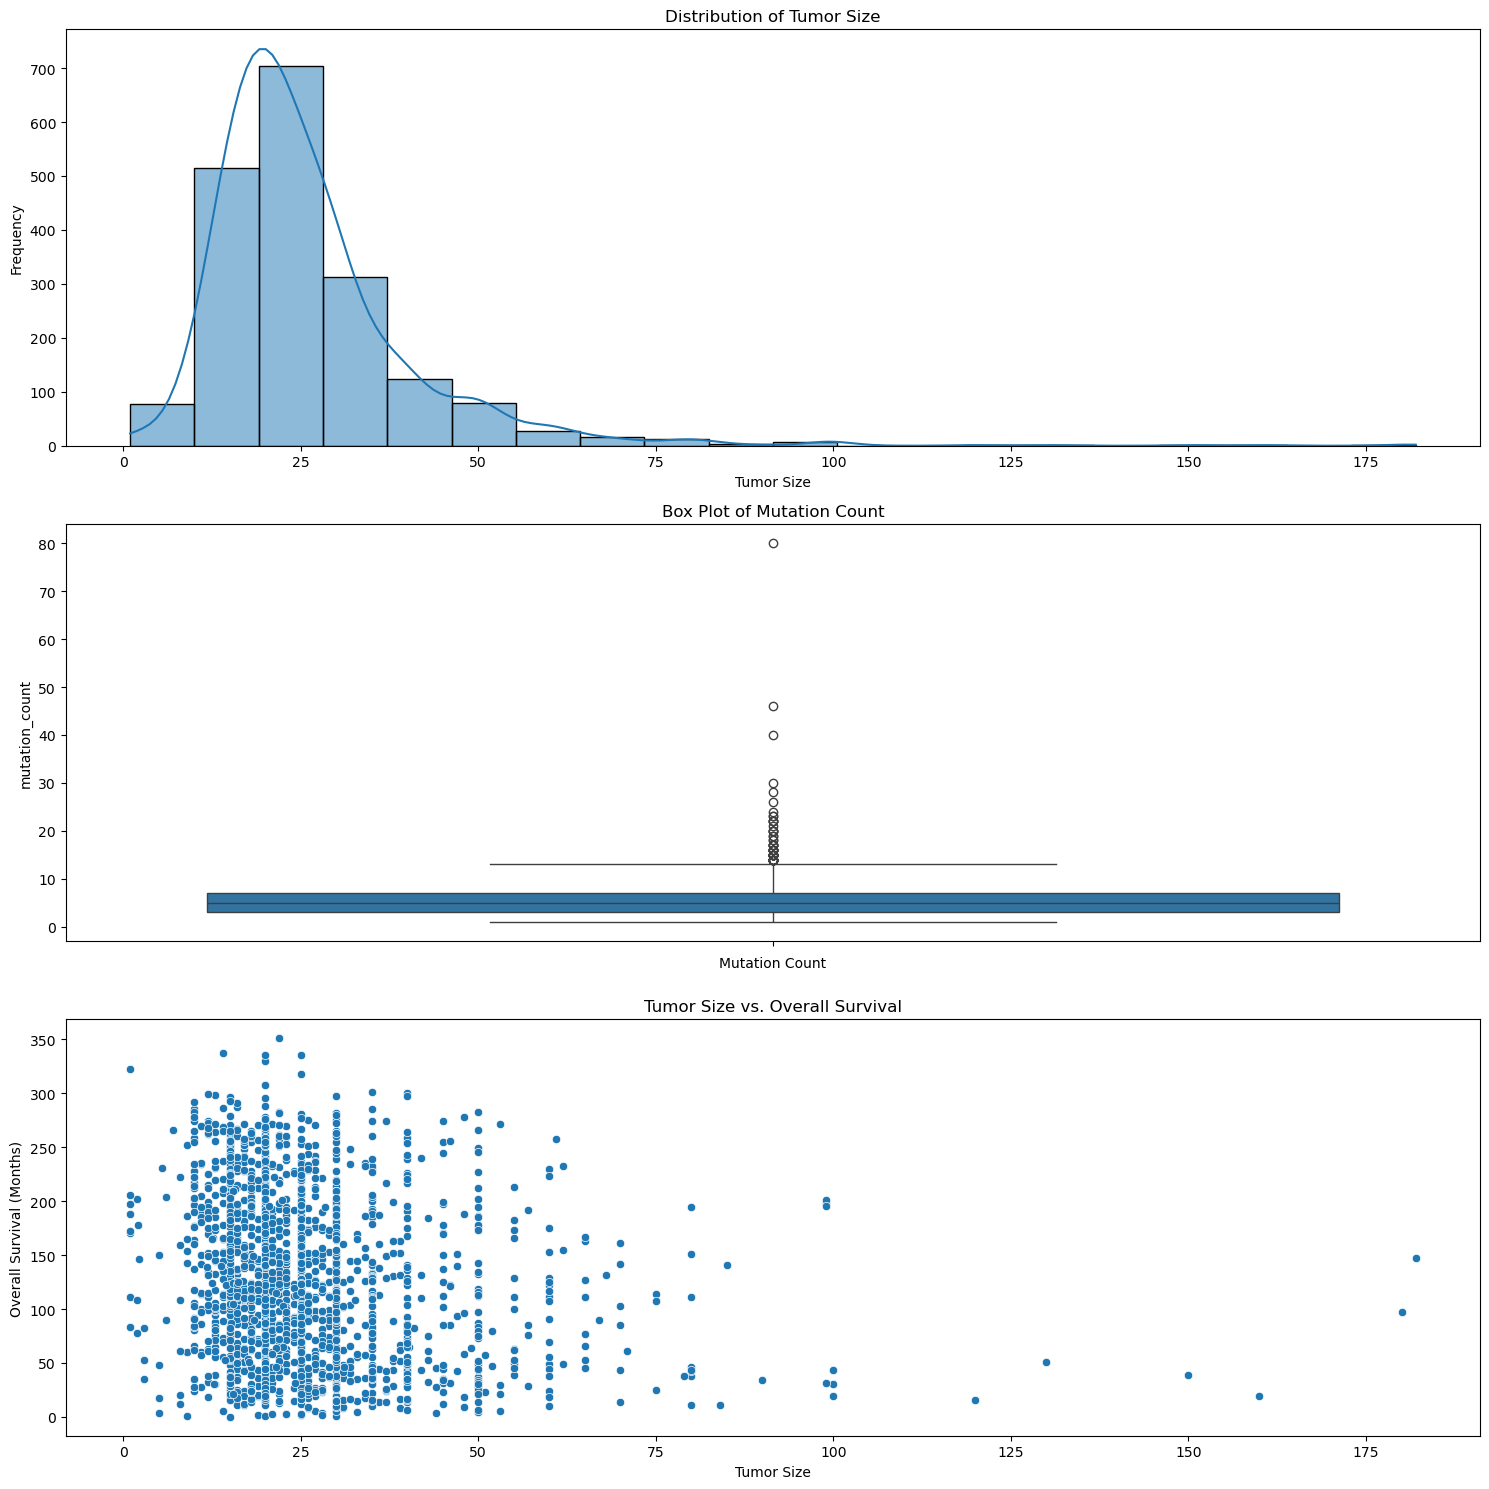

In [38]:
fig, axes = plt.subplots(3,1, figsize=(15, 15))
sns.histplot(data['tumor_size'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Tumor Size')
axes[0].set_xlabel('Tumor Size')
axes[0].set_ylabel('Frequency')


sns.boxplot(data['mutation_count'], ax=axes[1])
axes[1].set_title('Box Plot of Mutation Count')
axes[1].set_xlabel('Mutation Count')

sns.scatterplot(data=data, x='tumor_size', y='overall_survival_months', ax=axes[2])
# sns.boxplot(x='tumor_size', y='overall_survival_months', data=data, ax=axes[2])
axes[2].set_title('Tumor Size vs. Overall Survival')
axes[2].set_xlabel('Tumor Size')
axes[2].set_ylabel('Overall Survival (Months)')
plt.tight_layout()
plt.show()

**1. Distribution of tumor size**
* The histogram shows that most tumor sizes are in the range of 10-40
* There is a right-skewed distribution, meaning a few patients have very large tumors<br>
**Conclusion**
* Most patients have tumors in the lower size range, but there are a few cases with exceptionally large tumors
  
**2. From the box plot of mutation count**
* Q1 = 3
* Q2 = 5
* Q3 = 7
* top whisker is at (Q3 + 1.5(IQR) = 13)
* lower whisker is at (Q1 - 1.5(IQR) = -3, since mutation count cannot be -ve , so lower whisker is at 0)<br>
  **Conclusion**
* the outliers at the top indicate that some individuals have an unusually high mutation count compared to the majority of the data
* This suggests that while most individuals have mutation counts within a normal range (0–13), some have extreme values, possibly due to genetic factors, environmental influences, or errors in data collection

**3. Tumor size vs survival**
* The points are widely scattered
* Patients with small tumors (tumor size < 50) show a wide range of survival times (from very short to over 300 months)
* Some smaller tumors have low survival, while some larger tumors have high survival
* Some tumor sizes have a high variation in survival times, Some patients with the same tumor size live a short time, while others live much longer <br>
**Conclusion**
* Tumor size alone is not a perfect predictor of survival
* Other factors, like mutation count, treatment response, and patient health, likely influence survival

    

In [138]:
data.describe()

,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,1904.000000,1904.000000,1904.000000,1832.000000,1904.000000,1904.000000,1859.000000,1904.000000,1904.000000,1904.000000,...,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03
mean,61.087054,0.207983,2.643908,2.415939,0.616597,2.002101,5.697687,4.033019,125.121324,0.420693,...,4.726891e-07,-3.676471e-07,-9.453782e-07,-1.050420e-07,-0.000002,3.676471e-07,4.726891e-07,7.878151e-07,0.000000,3.731842e-18
std,12.978711,0.405971,1.228615,0.650612,0.486343,4.079993,4.058778,1.144492,76.334148,0.493800,...,1.000263e+00,1.000262e+00,1.000262e+00,1.000263e+00,1.000262,1.000264e+00,1.000262e+00,1.000263e+00,1.000262,1.000262e+00
min,21.930000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,-2.120800e+00,-3.364800e+00,-2.719400e+00,-4.982700e+00,-2.981700,-3.833300e+00,-3.609300e+00,-1.166900e+00,-2.112600,-1.051600e+00
25%,51.375000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,60.825000,0.000000,...,-6.188500e-01,-6.104750e-01,-6.741750e-01,-6.136750e-01,-0.632900,-6.664750e-01,-7.102000e-01,-5.058250e-01,-0.476200,-7.260000e-01
50%,61.770000,0.000000,3.000000,3.000000,1.000000,0.000000,5.000000,4.042000,115.616667,0.000000,...,-2.456500e-01,-4.690000e-02,-1.422500e-01,-5.175000e-02,-0.026650,7.000000e-04,-2.980000e-02,-2.885500e-01,-0.133400,-4.248000e-01
75%,70.592500,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.040250,184.716667,1.000000,...,3.306000e-01,5.144500e-01,5.146000e-01,5.787750e-01,0.590350,6.429000e-01,5.957250e-01,6.022500e-02,0.270375,4.284000e-01
max,96.290000,1.000000,5.000000,3.000000,1.000000,45.000000,80.000000,6.360000,355.200000,1.000000,...,6.534900e+00,1.027030e+01,6.329000e+00,4.571300e+00,12.742300,3.938800e+00,3.833400e+00,1.088490e+01,12.643900,3.284400e+00


# Data Processing

Feature we have to predict is the survival rate which can be attained from ```death_from_cancer```

In [65]:
data['death_from_cancer'].isnull().sum()

1

Since there is 1 null row, we need to filter out the rows where we have the data for the patients who has the value from 'death_from_cancer'
* For the clinical data we have 30 variables and those 30 variables are in the first 30 columns

In [114]:
data_survival = data[data['death_from_cancer'].notnull()].copy()
clinical_data = data_survival[data_survival.columns[:30]]
clinical_data

,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,...,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living
1,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,...,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living
2,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,...,4.030,IDC,163.700000,0,Positive,0,NaN,15.0,2.0,Died of Disease
3,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,...,4.050,MDLC,164.933333,1,Positive,1,NaN,25.0,2.0,Living
4,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,...,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,43.10,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,LumA,4.0,Positve,Positive,...,5.050,ILC,196.866667,1,Positive,1,ER+/HER2- Low Prolif,25.0,NaN,Living
1900,42.88,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,Positive,...,5.040,IDC,44.733333,0,Negative,1,NaN,20.0,NaN,Died of Disease
1901,62.90,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,Positive,...,6.050,IDC,175.966667,0,Positive,1,NaN,25.0,NaN,Died of Disease
1902,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,4.0,Positve,Positive,...,5.050,IDC,86.233333,0,Positive,0,ER+/HER2- High Prolif,25.0,NaN,Died of Other Causes


## Handle missing values

There are few types of missing data:
* Missing Completely at Random (MCAR) - The missingness is purely random and has no pattern, if we remove missing data, we still get an unbiased dataset
* Missing at Random (MAR) - Missingness is systematic but explainable, ignoring missing data may introduce bias.
* Missing Not at Random (MNAR) - In MNAR, the probability of a value being missing depends on unobserved data.

In [70]:
clinical_data.isna().sum()
missing_percentage = (clinical_data.isna().sum() / len(clinical_data)) * 100
missing_data = pd.DataFrame({
    'Total Missing Values': clinical_data.isna().sum(),
    'Percentage': (clinical_data.isna().sum() / len(clinical_data)) * 100
})
missing_data = missing_data.sort_values(by='Percentage', ascending=False)

print(missing_data)

                                Total Missing Values  Percentage
tumor_stage                                      501   26.326852
3-gene_classifier_subtype                        204   10.719916
primary_tumor_laterality                         106    5.570152
neoplasm_histologic_grade                         72    3.783500
cellularity                                       54    2.837625
mutation_count                                    45    2.364687
er_status_measured_by_ihc                         30    1.576458
type_of_breast_surgery                            22    1.156069
tumor_size                                        20    1.050972
tumor_other_histologic_subtype                    15    0.788229
cancer_type_detailed                              15    0.788229
oncotree_code                                     15    0.788229
nottingham_prognostic_index                        0    0.000000
age_at_diagnosis                                   0    0.000000
overall_survival_months  

The presence of too much missing data in the data set can negatively affect the precision and accuracy of the model. Generally, less than five percent missing values are an acceptable threshold. ```tumor_stage(26%)``` and ```3-gene_classifier_subtype(11%)``` have most of the missing values.

### Visualising missing values using missingno
1. The matrix
    * y axis is the row number
    * x-axis shows the features
    * the white line indicates the missing value on each row
2. Heatmap:
    * helps visualize correlations between missing values in different columns
    * A value near 1 means if one column has a missing value, the other column is also likely to have a missing value
    * A value near 0 means there is no dependence between the occurrence of missing values of two variables
    * A value near -1 means when one column is missing data, the other is usually present
    * If a column has no missing values at all, it won’t appear in the heatmap

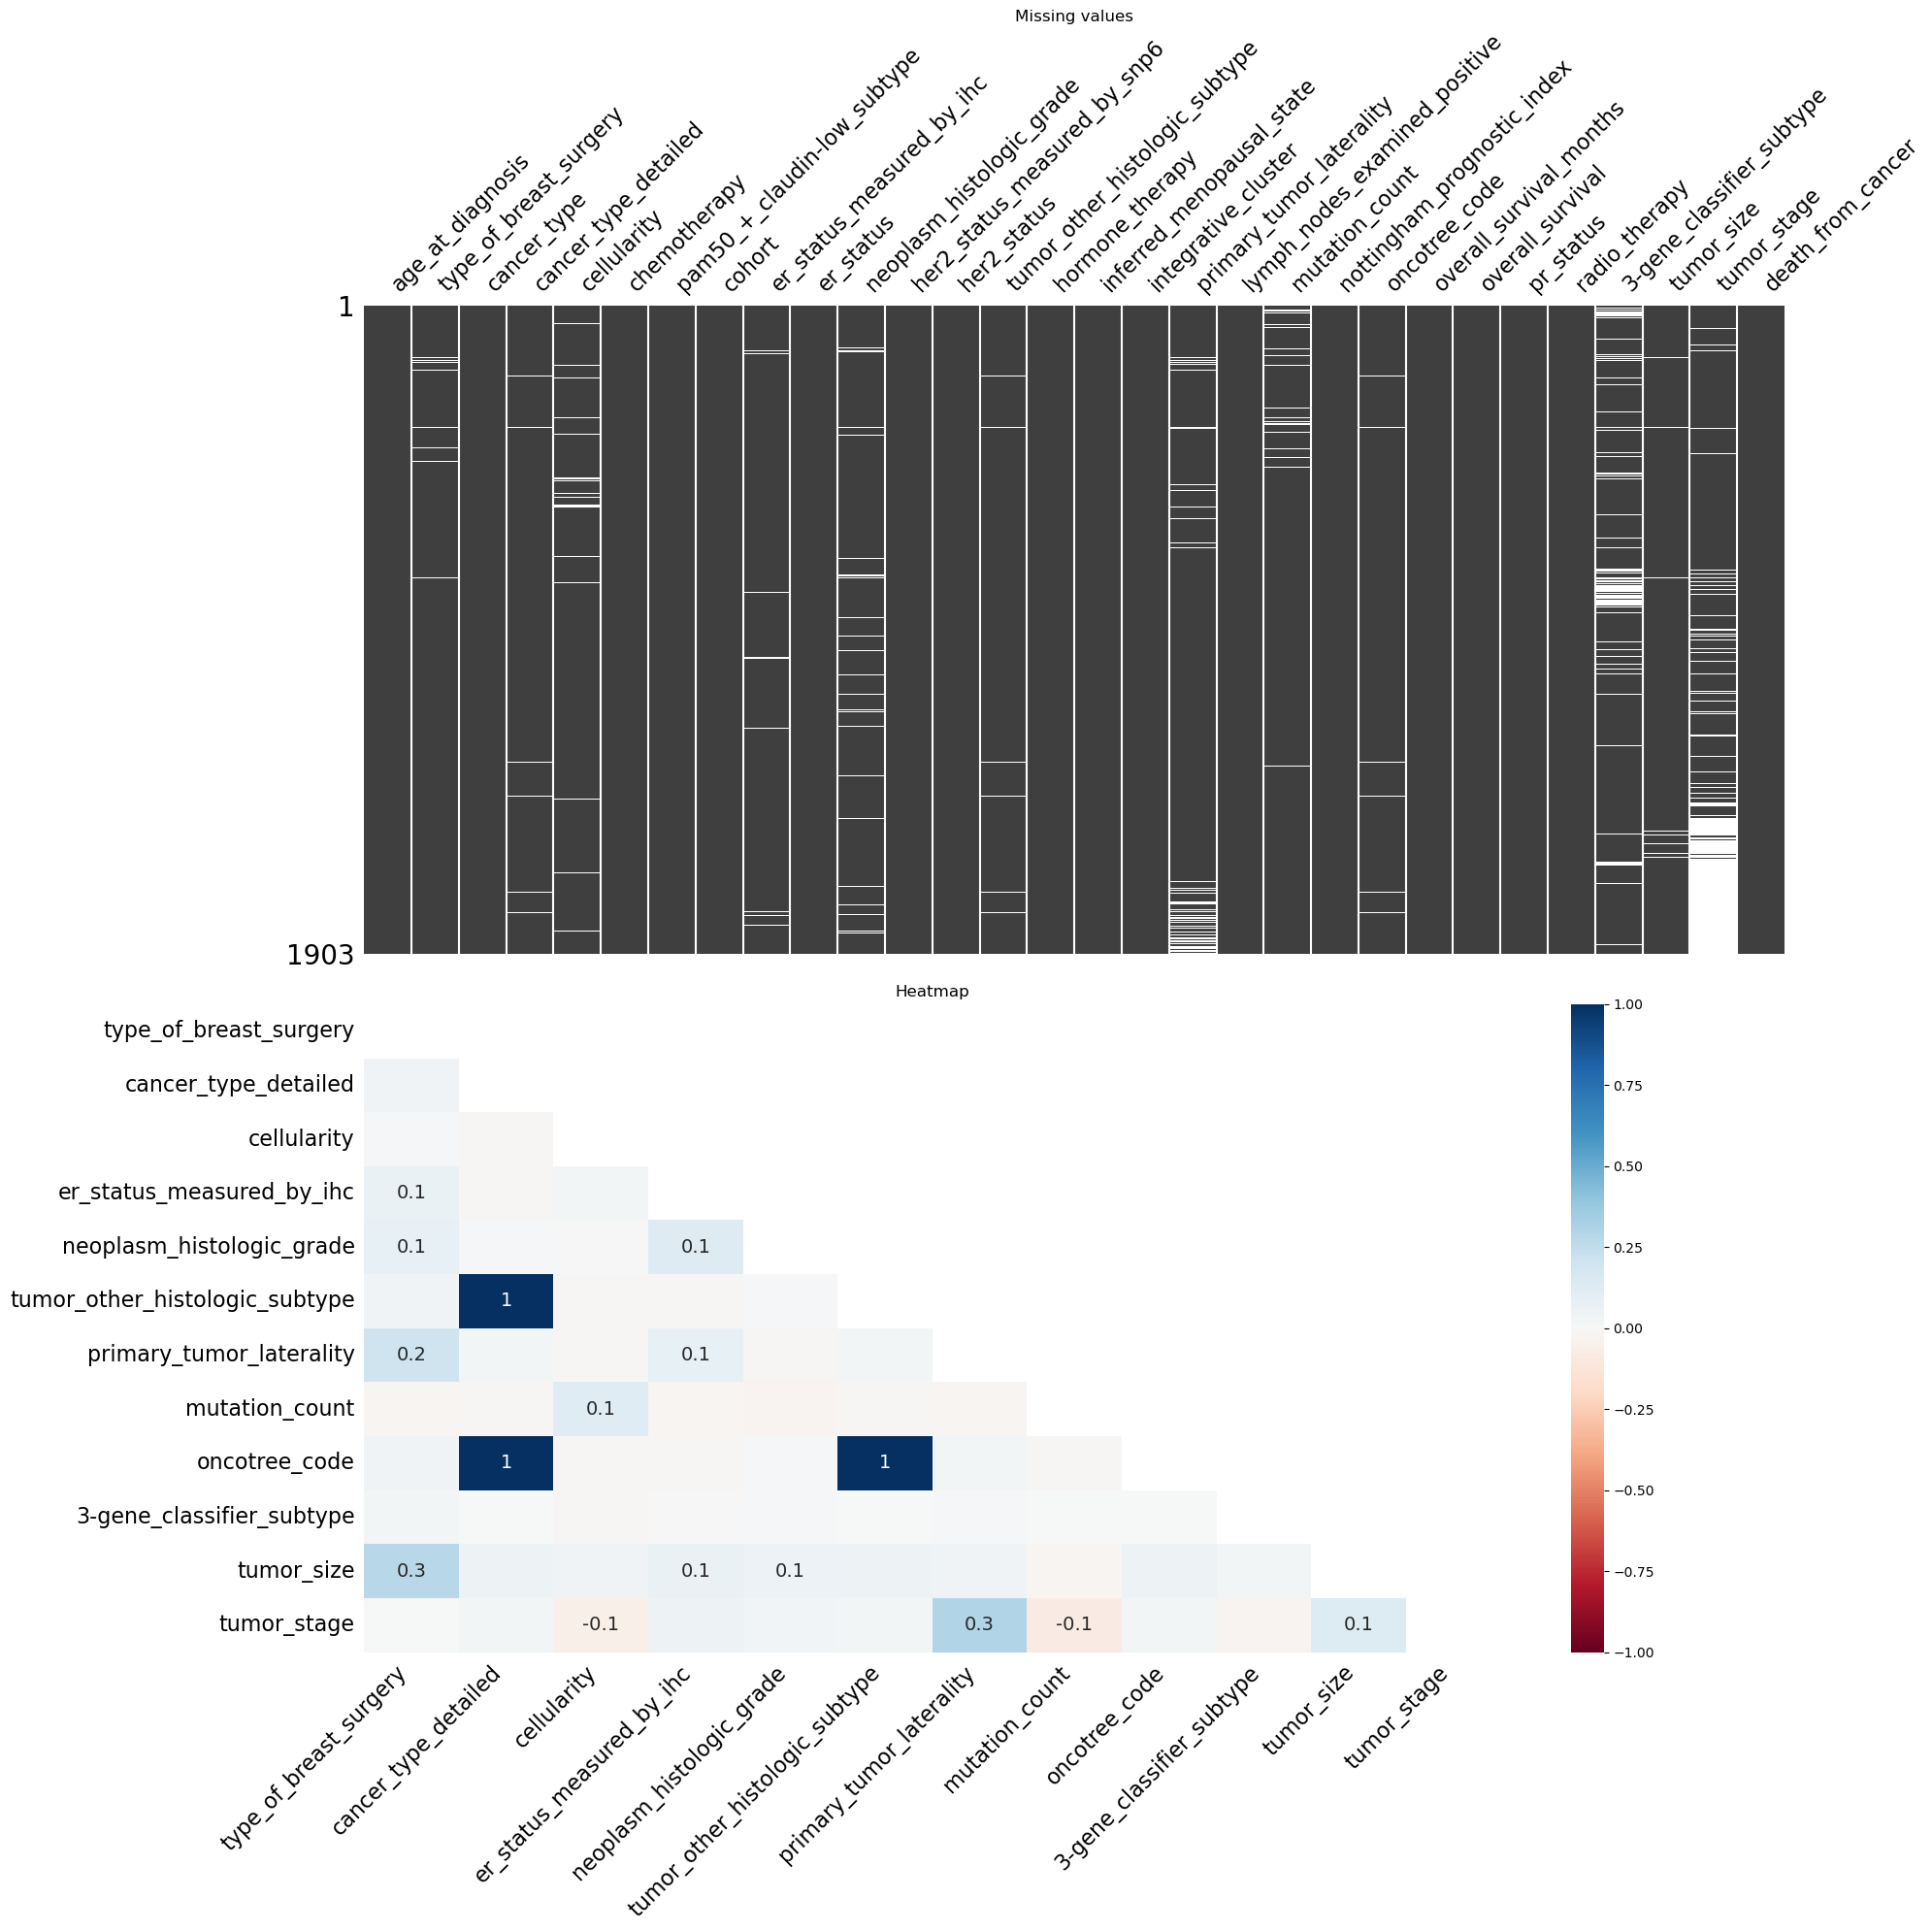

In [74]:
import missingno as msno

fig, axes = plt.subplots(2, 1, figsize=(20, 20))
ax1 = msno.matrix(clinical_data, ax=axes[0], sparkline=False)
ax1.set_title("Missing values")
ax2 = msno.heatmap(clinical_data, ax=axes[1])
ax2.set_title("Heatmap")

fig.tight_layout()
plt.show()


1. The matrix shows that the **tumor_stage** and **3-gene_classifier_subtype** has most of the missing values but it doesnt have any correlation with any of the missing data columns, which means they occur completely at random
   *  but we need to consider the columns which didnt had any missing values, eg: tumor stage will have some correlation with radio therapy
   *  therefore these variables are likely to have some correlation with other feature columns , hence its not completely at random
3. Heatmap:
    * ```tumor_other_histologic_subtype``` & ```cancer_type_detailed``` & ```oncotree_code``` shows high correlation of 1 indicating that if one of the values in any of these columns are missing then the other column values will also be missing :**MNAR type**
    * from the matrix we can confirm that whenever one of these values are missing the other column values are also missing for the same row
    * this means that they are strongly linked in terms of missing data and we need to use only one of the columns( redundant columns)
      
We have a combination of MAR(missing at random) and MNAR(Missing not at random) types <br>
```In that case we can use Multiple imputation to deal with missing values```

### Convert categorical to numeric representation

#### Encode target variable

In [116]:
clinical_data['death_from_cancer'].value_counts()

death_from_cancer
Living                  801
Died of Disease         622
Died of Other Causes    480
Name: count, dtype: int64

In [203]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder() # it should only be used for target values ie, y and not x
clinical_data.loc[:,'death_from_cancer']= encoder.fit_transform(clinical_data['death_from_cancer'])
clinical_data.loc[:,'death_from_cancer'] = pd.to_numeric(clinical_data['death_from_cancer'], errors='coerce').astype('Int64')
print(clinical_data.head())


   age_at_diagnosis type_of_breast_surgery    cancer_type  \
0             75.65             MASTECTOMY  Breast Cancer   
1             43.19      BREAST CONSERVING  Breast Cancer   
2             48.87             MASTECTOMY  Breast Cancer   
3             47.68             MASTECTOMY  Breast Cancer   
4             76.97             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4  Breast Mixed Ductal and Lobular Carcinoma        High             1   

  pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc er_status  \
0                 claudin-low     1.0                   Positve  Positive   
1                        LumA     

#### Encode feature variables

In [199]:
# now for the feature columns, we convert categorical variables into multiple binary columns (one-hot encoding)
clinical_data_encoded = pd.get_dummies(clinical_data, dtype='int')
clinical_data_encoded['cancer_type_Breast Cancer'].value_counts()

# replace the special characters in the column names with _
import re
clinical_data_encoded.columns = [
    re.sub(r'[!@#$%^&*(){}\[\];:,./<>?\\|`~\=_\']', '_', col)
    for col in clinical_data_encoded.columns
]
clinical_data_encoded.describe()

,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,...,oncotree_code_ILC,oncotree_code_IMMC,oncotree_code_MBC,oncotree_code_MDLC,pr_status_Negative,pr_status_Positive,3-gene_classifier_subtype_ER+_HER2- High Prolif,3-gene_classifier_subtype_ER+_HER2- Low Prolif,3-gene_classifier_subtype_ER-_HER2-,3-gene_classifier_subtype_HER2+
count,1903.000000,1903.000000,1903.000000,1831.000000,1903.000000,1903.000000,1858.000000,1903.000000,1903.000000,1903.000000,...,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000
mean,61.088355,0.208092,2.643720,2.415620,0.616921,2.003153,5.693757,4.033020,125.053074,0.420914,...,0.074619,0.011561,0.000525,0.108776,0.470310,0.529690,0.316343,0.325276,0.152391,0.098791
std,12.981999,0.406050,1.228911,0.650646,0.486265,4.080807,4.056331,1.144792,76.296083,0.493836,...,0.262845,0.106925,0.022923,0.311439,0.499249,0.499249,0.465171,0.468601,0.359494,0.298460
min,21.930000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.370000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,60.783333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,61.780000,0.000000,3.000000,3.000000,1.000000,0.000000,5.000000,4.042000,115.600000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,70.595000,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.040500,184.550000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,96.290000,1.000000,5.000000,3.000000,1.000000,45.000000,80.000000,6.360000,355.200000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Encoding fills the categorical variables whose values is missing with 0, since tumor_stage has the most missing values and its not categorical we can impute the values of those and the rest columns like 3-gene_classifier_subtype will be filled with 0 in case the value is missing, and since it has only a small percentage of missing values wont cause any disturb 

In [179]:
missing_percentage = (clinical_data_encoded.isna().sum() / len(clinical_data_encoded)) * 100
missing_data = pd.DataFrame({
    'Total Missing Values': clinical_data_encoded.isna().sum(),
    'Percentage': (clinical_data_encoded.isna().sum() / len(clinical_data_encoded)) * 100
})
missing_data = missing_data.sort_values(by='Percentage', ascending=False)
print(missing_data)

                                   Total Missing Values  Percentage
tumor_stage                                         501   26.326852
neoplasm_histologic_grade                            72    3.783500
mutation_count                                       45    2.364687
tumor_size                                           20    1.050972
integrative_cluster_4ER+                              0    0.000000
...                                                 ...         ...
pam50_+_claudin-low_subtype_Her2                      0    0.000000
pam50_+_claudin-low_subtype_Basal                     0    0.000000
cellularity_Moderate                                  0    0.000000
cellularity_Low                                       0    0.000000
3-gene_classifier_subtype_HER2+                       0    0.000000

[79 rows x 2 columns]


#### Data Imputation

In [197]:
import miceforest as mf

# Create Kernel
clinical_data_encoded = clinical_data_encoded.reset_index(drop=True)

kds = mf.ImputationKernel(
  data=clinical_data_encoded,
  random_state=1991
)

# Run the MICE algorithm for 2 iteration
kds.mice(2)

# Return the completed dataset.
new_data = kds.complete_data()
print(new_data.describe())

# Saving the cleaned data to a new file
new_data.to_csv("Dataset/final_dataset.csv", index=False)

       age_at_diagnosis  chemotherapy       cohort  neoplasm_histologic_grade  \
count       1903.000000   1903.000000  1903.000000                1903.000000   
mean          61.088355      0.208092     2.643720                   2.366789   
std           12.981999      0.406050     1.228911                   0.687113   
min           21.930000      0.000000     1.000000                   1.000000   
25%           51.370000      0.000000     1.000000                   2.000000   
50%           61.780000      0.000000     3.000000                   2.000000   
75%           70.595000      0.000000     3.000000                   3.000000   
max           96.290000      1.000000     5.000000                   3.000000   

       hormone_therapy  lymph_nodes_examined_positive  mutation_count  \
count      1903.000000                    1903.000000     1903.000000   
mean          0.616921                       2.003153        5.632685   
std           0.486265                       4.0808

# Model Training

In [191]:
df = pd.read_csv("./Dataset/final_dataset.csv", engine="python")
x = df.loc[:,df.columns != 'death_from_cancer']
y = df['death_from_cancer']